In [1]:
import pandas as pd
import numpy as np
from copy import copy
import torch
import matplotlib.pyplot as plt
from google.colab import drive
from IPython.display import clear_output
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
def file_to_data(filename):
    
    # read file
    raw = pd.read_csv(filename)
    
    # define columns to be extracted
    ndvi_col = ['ndvi_mean'+str(i) for i in range(1, 24+1)] # ndvi_mean1, ..., ndvi_mean24
    savi_col = ['ndvi_mean'+str(i) for i in range(1, 24+1)] # ndvi_mean1, ..., savi_mean24
    evi_col = ['ndvi_mean'+str(i) for i in range(1, 24+1)] # ndvi_mean1, ..., evi_mean24

    # extract each feature
    ndvi_timeseries = raw[ndvi_col]
    savi_timeseries = raw[savi_col]
    evi_timeseries = raw[evi_col]
    
    # dimension stack
    data = np.dstack([ndvi_timeseries, savi_timeseries, evi_timeseries])
    
    # get only label
    label = raw.iloc[:, -1]
    
    return data, label

def data_to_lv1_x_y(data, labels):
    
    # export all X
    # but reclass the plant cane -> 100, ratoon cane -> 200
    target = copy(labels)
    target[target > 200] = 200
    target[(target < 200) & (target > 100)] = 100
    
    return data, target

def data_to_lv2_x_y(data, target):
    
    # export X plant which labels are 100-200
    X_plant = data[(target > 100) & (target <200)]
    
    # export X ratoon which labels are >200
    X_ratoon = data[target > 200]
    
    # export y plant which labels are 100-200
    y_plant = target[(target > 100) & (target < 200)]
    
    # export y ratoon which labels are >200
    y_ratoon = target[target > 200]
    
    return X_plant, y_plant, X_ratoon, y_ratoon

def label_encode(y):
    
    target = copy(y)
    # redefine the cane plantation label to be 1 - 24
    new_y = [int(str(label)[1:]) for label in target]
    
    return np.array(new_y)

In [3]:
data_train, labels_train = file_to_data('/content/drive/MyDrive/AIT/ML/training_data_1718.csv')
data_test, labels_test = file_to_data('/content/drive/MyDrive/AIT/ML/training_data_1819.csv')

In [4]:
X_train, y_train = data_to_lv1_x_y(data_train, labels_train)
X_test, y_test = data_to_lv1_x_y(data_test, labels_test)

In [5]:
from sklearn.preprocessing import LabelEncoder

lu_encoder = LabelEncoder()

y_train = lu_encoder.fit_transform(y_train)
y_test = lu_encoder.transform(y_test)

In [6]:
print(f'numeric class of y train: {np.unique(y_train)}')
print(f'numeric class of y test: {np.unique(y_test)}')

numeric class of y train: [ 0  1  2  3  4  5  6  7  8  9 10 11]
numeric class of y test: [ 0  1  2  3  4  5  6  7  8  9 10 11]


In [7]:
y_train[y_train>9] = 10
y_test[y_test > 9] = 10

In [8]:
print(f'numeric class of y train: {np.unique(y_train)}')
print(f'numeric class of y test: {np.unique(y_test)}')

numeric class of y train: [ 0  1  2  3  4  5  6  7  8  9 10]
numeric class of y test: [ 0  1  2  3  4  5  6  7  8  9 10]


In [9]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

In [10]:
shape = X_train.shape
print(Counter(y_train))

Counter({10: 12367, 0: 118, 1: 92, 2: 85, 4: 30, 5: 30, 7: 30, 9: 30, 8: 30, 3: 26, 6: 22})


In [11]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_train.shape

(12860, 72)

In [12]:
# instantiating the random over sampler 
ros = RandomOverSampler()
# resampling X, y
X_train, y_train = ros.fit_resample(X_train, y_train)

print(f'after oversampled-> X shape: {X_train.shape}')

after oversampled-> X shape: (136037, 72)


In [13]:
X_train = X_train.reshape(X_train.shape[0], 24,3)
X_train.shape

(136037, 24, 3)

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train  , test_size=0.3)

In [15]:
X_train_ndvi = X_train[:,0,:]
X_valid_ndvi = X_valid[:,0,:]
X_train_savi = X_train[:,1,:]
X_valid_savi = X_valid[:,1,:]
X_train_evi = X_train[:,2,:]
X_valid_evi = X_valid[:,2,:]

In [16]:
from sklearn.svm import SVC # "Support vector classifier"
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split

model = SVC(gamma='auto',max_iter = 1000)

model.fit(X_train_ndvi, y_train)
yhat = model.predict(X_valid_ndvi) #svm use this instead

#plot precision recall curve
from sklearn.metrics import average_precision_score, classification_report, confusion_matrix
print("=========Classification report=======")
print("Report: ", classification_report(y_valid, yhat))

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


=========Classification report=======
Report:                precision    recall  f1-score   support

           0       0.96      1.00      0.98      3751
           1       0.00      0.00      0.00      3682
           2       0.00      0.00      0.00      3636
           3       0.00      0.00      0.00      3758
           4       0.00      0.00      0.00      3733
           5       0.00      0.00      0.00      3755
           6       1.00      0.05      0.09      3782
           7       0.27      0.27      0.27      3744
           8       0.05      0.06      0.06      3639
           9       0.00      0.00      0.00      3671
          10       0.08      0.59      0.14      3661

    accuracy                           0.18     40812
   macro avg       0.21      0.18      0.14     40812
weighted avg       0.22      0.18      0.14     40812



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [18]:
X_test = X_test.reshape(X_test.shape[0], 24,3)
X_test_ndvi = X_test[:,0,:]

In [19]:
y_preds = model.predict(X_test_ndvi)
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       118
           1       0.00      0.00      0.00        92
           2       0.00      0.00      0.00        85
           3       0.00      0.00      0.00        26
           4       0.00      0.00      0.00        30
           5       0.00      0.00      0.00        30
           6       1.00      0.05      0.09        22
           7       0.01      0.27      0.02        30
           8       0.00      0.07      0.00        30
           9       0.00      0.00      0.00        30
          10       0.93      0.48      0.63      7452

    accuracy                           0.47      7945
   macro avg       0.27      0.17      0.16      7945
weighted avg       0.89      0.47      0.61      7945



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(33.0, 0.5, 'predicted')

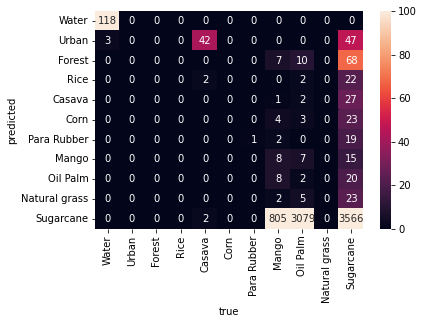

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cf_matrix_plant = confusion_matrix(y_test, y_preds)
xticklabels = ["Water", "Urban", "Forest", "Rice", "Casava", "Corn", "Para Rubber", "Mango", "Oil Palm", "Natural grass", "Sugarcane"]
yticklabels = ["Water", "Urban", "Forest", "Rice", "Casava", "Corn", "Para Rubber", "Mango", "Oil Palm", "Natural grass", "Sugarcane"]

sns.heatmap(cf_matrix_plant, fmt="d",vmax=100 ,annot=True,xticklabels=xticklabels, yticklabels=yticklabels)
plt.xlabel('true')
plt.ylabel('predicted')